## Machine Learning - Project: Face recognitions


Submitted by: [Slavik Lozver]

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize

from sklearn.svm import SVC 
from PIL import Image

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

#to print the heat map
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [2]:
def read_image():  #loading all the data
    path = 'att_faces'
    X = []
    y = []
    for i in range(40):
        for j in range(10):
            img = Image.open(os.path.join(path,'s'+str(i+1),str(j+1)+'.pgm'))
            X.append(np.asarray(img,dtype=np.uint8).flatten())
            y.append(i)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [3]:
#-------------------------------------- SVM -----------------------------------------#
def face_rec_svm(X,y,n_comp, gamma= 0.0001, C=100):
    #spliting the training data and the testing data
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)  
    
    pca = PCA(n_components = n_comp, whiten=True) # reducing the dimension with the pca algorithm 
    X_trn_pca = pca.fit_transform(X_trn)
    X_tst_pca= pca.transform(X_tst)
    
    eigenfaces = pca.components_.reshape((n_comp, 112, 92))  #saving the eigenfaces
    
   
    sv = SVC(kernel='rbf',gamma = gamma, C=C)
    sv.fit(X_trn_pca,y_trn) # fitting the training data 

    y_pred = sv.predict(X_tst_pca)
    
    return y_pred, y_tst, X_tst, eigenfaces
    

In [4]:
def find_best_d(X):
    pca = PCA(n_components = 401, whiten=True) # reducing the dimension with the pca algorithm 
    X_pca = pca.fit_transform(X)
    var_arr = pca.explained_variance_  #variance array
    best_d=0;
    for i in range (len(var_arr)-1):
        if(var_arr[i] < var_arr[i+1]*1.005):  #the next variance is only 0.005% bigger then the current
            break;
    best_d=i+1
    print("the best dimension is: ", best_d) #ploting the variance graph
    plt.plot(var_arr)
    plt.plot(best_d,var_arr[best_d], 'or')
    plt.title("Variance as a function of Dimension")
    plt.ylabel('Variance')
    plt.xlabel('Dimension')
    plt.grid()
    plt.show()
    return best_d

the best dimension is:  78


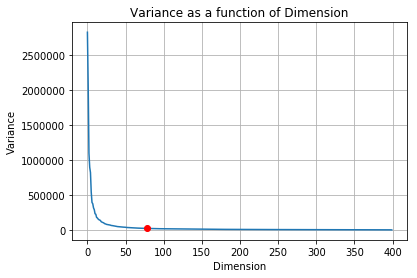

In [5]:
X,y = read_image() #reading the data

def mis_count_svm(X,y, min_d,): #countin the misclassifications
    r,comp =X.shape
    dim = [2, min_d ,300]
    mis = np.zeros(3) # count the missclassifications
    
    for i in range(3):
        d=dim[i]
        c, gamma = find_best_para(X,y,d,0)   # finding the best c, and gamma for current dimension
        y_pred, y_tst, X_tst, eigenfaces= face_rec_svm(X,y,d, gamma, c)
        for j in range(len(y_tst)):
            if (y_pred[j]!=y_tst[j]):
                mis[i]+=1
        print("dimension: ", d)
        print("misclassifications: ", mis[i])
min_d=find_best_d(X)


The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.95


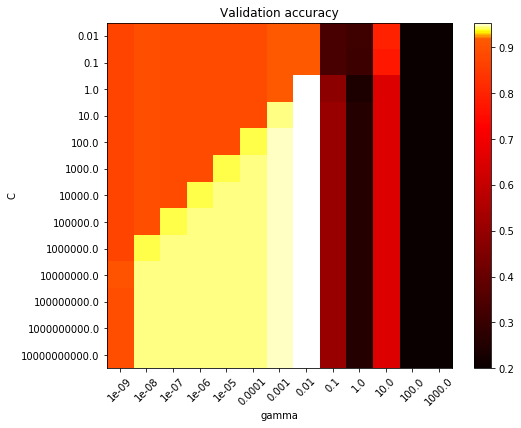

In [6]:

## finding the best gamma and C
def find_best_para(X,y,min_d, plot=1):
    pca = PCA(n_components = min_d, whiten=True) # reducing the dimension with the pca algorithm 
    X_pca = pca.fit_transform(X)
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(gamma=gamma_range, C=C_range)
    
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
    grid.fit(X_pca, y)
    
    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))

    scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),  # for ploting the score in the heat map
                                                         len(gamma_range)) 

    #plotting an heat map of the parameters
    if(plot ==1):
        plt.figure(figsize=(8, 6))                                 
        plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
        plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
                   norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
        plt.xlabel('gamma')
        plt.ylabel('C')
        plt.colorbar()
        plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
        plt.yticks(np.arange(len(C_range)), C_range)
        plt.title('Validation accuracy')
        plt.show()

    return grid.best_estimator_.C, grid.best_estimator_.gamma

best_C , best_gamma = find_best_para(X,y,min_d)



The best parameters are {'C': 100000.0, 'gamma': 0.01} with a score of 0.45
dimension:  2
misclassifications:  40.0
The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.96
dimension:  78
misclassifications:  4.0
The best parameters are {'C': 0.01, 'gamma': 0.001} with a score of 0.64
dimension:  300
misclassifications:  80.0
the eigen-faces: 


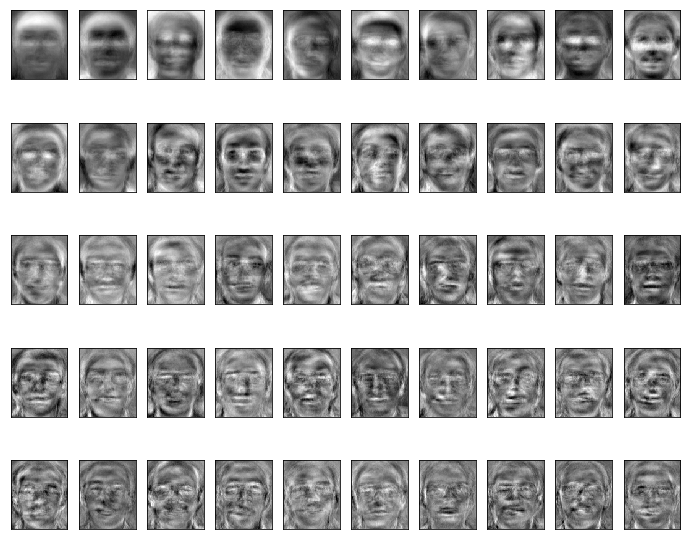

In [7]:
#print the eigenfaces

mis_count_svm(X,y,min_d) # counting the misclassification of each dimension
y_pred, y_tst, X_tst,eigenfaces = face_rec_svm(X,y,min_d, best_C, best_gamma)
h=112
w=92
plt.figure(figsize=(12,10))
print("the eigen-faces: ")
for i in range(50):  # ploting the 50 first eigen faces
        plt.subplot(5, 10, i + 1)
        plt.imshow(eigenfaces[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())


predicted: (random)


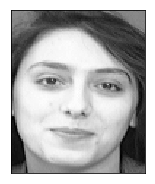

all faces of the predicted person: (in test data)


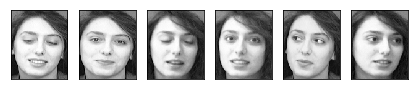

In [17]:
## function that prints the image of the predicted randomely face and all his rest faces in the test data
def face_check(X_tst, y_pred, y_tst):  
    num = np.random.randint(0,len(y_pred))  # random face 
    plt.figure(figsize=(5,3))
    print("predicted: (random)")
    plt.imshow(X_tst[num].reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    print("all faces of the predicted person: (in test data)")
    j=0
    plt.figure(figsize=(12,10))
    for i in range(len(y_tst)):   
        if(y_pred[num]== y_tst[i]): # showing the rest faces of the same person that we predicted 
            plt.subplot(3, 10, j + 1)
            plt.imshow(X_tst[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.xticks(())
            plt.yticks(())
            j+=1
face_check(X_tst, y_pred, y_tst)

In [13]:
#-------------------------------------- LogisticRegression -----------------------------------------#
def face_rec_log_reg(X,y,n_comp,c=1.0):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.20, random_state=42)  
    
    pca = PCA(n_components = n_comp, whiten=True) # reducing the dimension with the pca algorithm 
    X_trn_pca = pca.fit_transform(X_trn)
    X_tst_pca= pca.transform(X_tst)
    eigenfaces = pca.components_.reshape((n_comp, 112, 92))  #saving the eigenfaces
    
    logreg= LogisticRegression(C=c)
    logreg.fit(X_trn_pca,y_trn)
    y_pred = logreg.predict(X_tst_pca)
    
    return y_pred, y_tst, X_tst, eigenfaces
    

In [18]:
def mis_count_log(X,y, min_d,): #countin the misclassifications
    r,comp =X.shape
    dim = [2, min_d ,300]
    mis = np.zeros(3)
    
    for i in range(3):
        d=dim[i]
        y_pred, y_tst, X_tst, eigenfaces= face_rec_log_reg(X,y,d)
        for j in range(len(y_tst)):
            if (y_pred[j]!=y_tst[j]):
                mis[i]+=1
        print("dimension: ", d)
        print("misclassifications: ", mis[i])

dimension:  2
misclassifications:  67.0
dimension:  78
misclassifications:  2.0
dimension:  300
misclassifications:  3.0
the 50 first eigen-faces: 


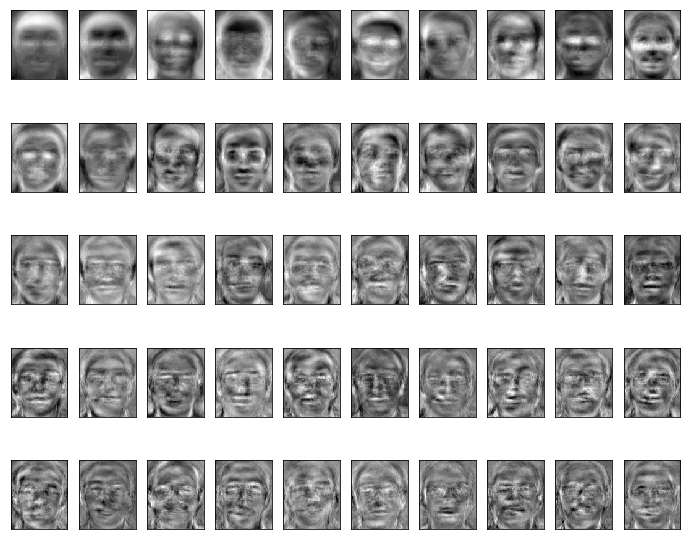

In [19]:
mis_count_log(X,y,min_d)

y_pred, y_tst, X_tst,eigenfaces_log = face_rec_log_reg(X,y,min_d) 

h=112
w=92
plt.figure(figsize=(12,10))
print("the 50 first eigen-faces: ")
for i in range(50):  # ploting the eigen faces
        plt.subplot(5, 10, i + 1)
        plt.imshow(eigenfaces_log[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
        
